# Modelling neural connectivity from fMRI data using  Bayesian Networks
### by Mattia Orlandi

This project was developed as part of the **Fundamentals of Artificial Intelligence and Knowledge Representation (Mod. 3)** course of the **Master in Artificial Intelligence** (*Alma Mater Studiorum, University of Bologna*).

In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

from nilearn import datasets, image, plotting
from nilearn.decomposition import CanICA
from nilearn.input_data import NiftiMapsMasker

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pgmpy.models import BayesianModel, DynamicBayesianNetwork
from pgmpy.estimators import BDeuScore, BayesianEstimator
from pgmpy.inference import VariableElimination
from pgmpy.sampling import BayesianModelSampling
from tslearn.metrics import dtw

import nc

import time
from random import sample
from collections import Counter
import warnings

warnings.filterwarnings("ignore")

/usr/local/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/usr/local/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


## Introduction
*Functional magnetic resonance imaging* (**fMRI**) is a neuro-imaging technique which measures brain activity by detecting changes in the blood flow: in fact, when a specific brain region is in use, the blood flow in that region will increase, creating the so-called *blood-oxygen-level dependent* (**BOLD**) signal.
Such signal is the result of a superimposition of the activities of several local regions.

The aim of this project is to use **discrete Dynamic Bayesian Networks** (dDBNs) to analyse the BOLD signal of an fMRI in order to estimate a model for neural connectivity, and thus show how the brain regions involved interacts with each other; to do so, the *movie watching based brain development* dataset [[1](#first)], composed of fMRI data from both children and adults collected during a movie-watching task, is considered.

Finally, the dDBN's predicting performances will be assessed by comparing it with a (random) baseline.

This project makes use of the following libraries:
- `nilearn`, which provides neuroimaging tools;
- `pgmpy`, which provides support for Bayesian networks;
- `tslearn`, which provides tools for time series analysis. 

The `pgmpy` library currently [does not fully support learning continuous models](https://github.com/pgmpy/pgmpy/issues/1072); this is the reason why in this project a discrete DBN is employed.

To simplify this notebook, the most complex functions are wrapped in the `nc` custom module.

## Data preprocessing

Firstly, the dataset is fetched using `nilearn` APIs. In particular, the data concerning only 30 adult subjects out of 155 is loaded (mixing data from children and adult subjects would distort results, since brain connectivity is very different for these two categories).

In [2]:
# Fetch dataset
data = datasets.fetch_development_fmri(n_subjects=30, age_group="adult", data_dir=".")
data.keys()

dict_keys(['func', 'confounds', 'phenotypic', 'description'])

As it can be seen, the dataset is a dictionary containing four keys:
- **func**: paths to Nifti files, containing the downsampled fMRI (4D) images for each subject;
- **confounds**: paths to CSV files containing the nuisance variables (i.e. *confounds*) to take into account in order not to affect the analysis;
- **phenotypic**: information about subjects (e.g. age, age group, gender, etc.);
- **description**: a description of the dataset.

As previously mentioned, fMRI signal is the summation of the signals coming from multiple regions; therefore, the next step consists in separating such signal into simpler, non-overlapping spatial and time components. This can be done using **Canonical Independent Component Analysis** (*CanICA*) [[2](#second)]: `nilearn` provides the `CanICA` class which implements such algorithm. The documentation suggests a 20-component decomposition, but that would have resulted into a Bayesian network with 40 nodes (20 for the current time slice, and 20 for the following one). A network with such a high number of nodes would take a lot of time to perform search tasks (i.e. find the best network structure, find independencies between nodes, or perform sampling). Therefore, an 8-component decomposition was chosen.

In [3]:
# Perform Independent Component Analysis (ICA)
canica = CanICA(
    n_components=8,
    mask_strategy="template",
    verbose=1,
    memory="nilearn_cache",
    memory_level=1,
    random_state=42,
)
canica.fit(data.func)

# Retrieve the components
components_img = canica.components_img_

[MultiNiftiMasker.fit] Loading data from [development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,
 development_fmri/development_fmri/sub-pixar124_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,
 development_fmri/development_fmri/sub-pixar125_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,
 development_fmri/development_fmri/sub-pixar126_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,
 development_fmri/development_fmri/sub-pixar127_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,
 development_fmri/development_fmri/sub-pixar128_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,
 development_fmri/development_fmri/sub-pixar129_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,
 development_fmri/development_fmri/sub-pixar130_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,
 development_fmri/development_fmri/sub-pixar131_task-pixar_space-MNI152

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   45.8s finished


Once the components have been extracted, it's possible to plot the ICs using two `nilearn` functions: `plot_prob_atlas()` stacks all the ICs as layers on top of the default anatomical brain image, whereas `plot_stat_map()` allows to plot cuts of the region of interest (ROI).

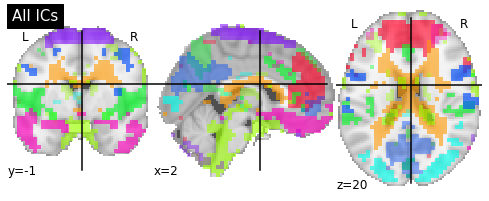

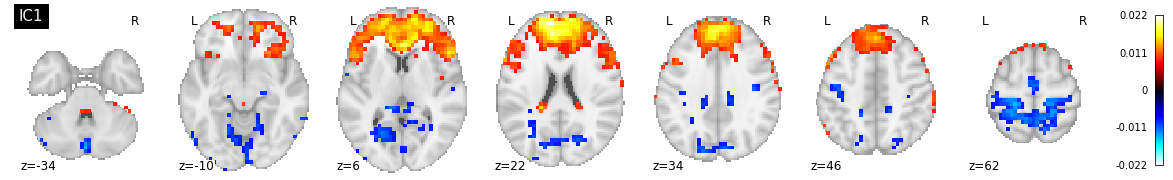

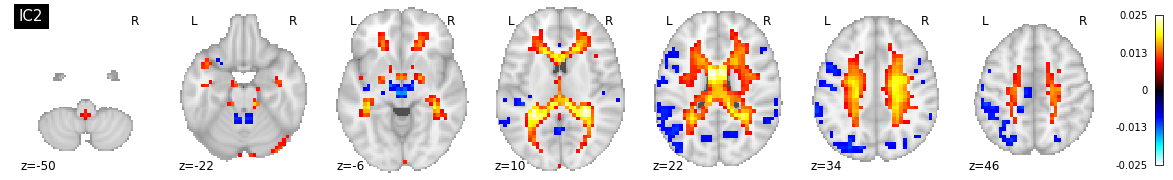

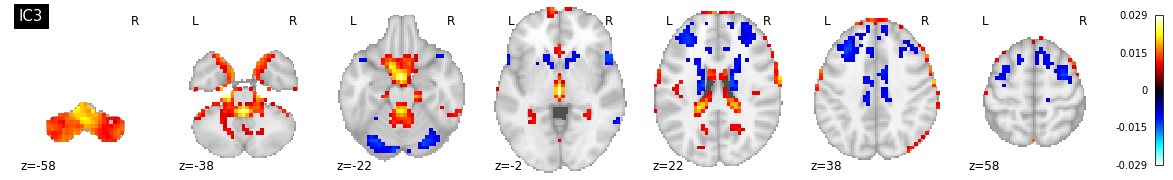

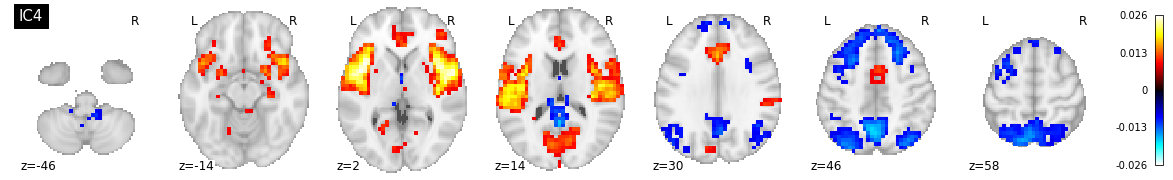

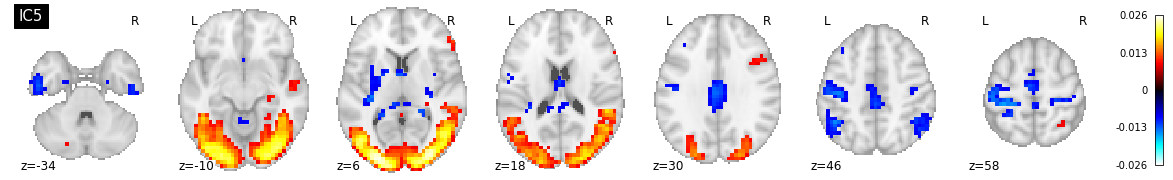

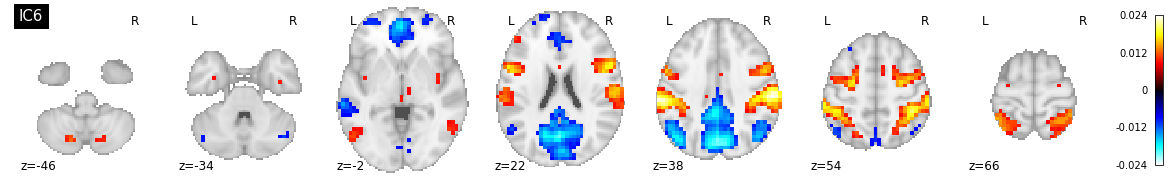

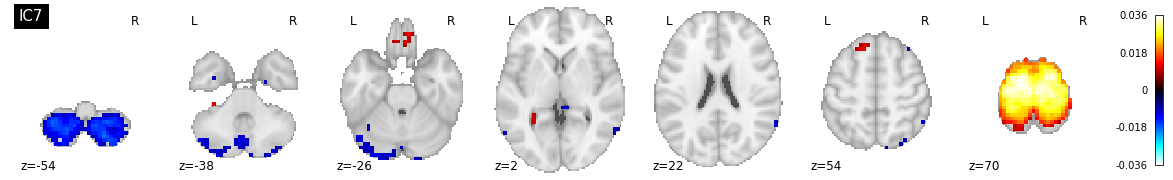

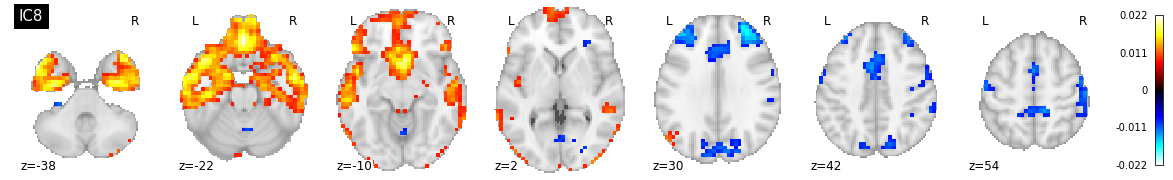

In [4]:
# Plot all ICs in a single image
plotting.plot_prob_atlas(components_img, title="All ICs")
plotting.show()

# Plot every IC in a separate image
for i, cur_img in enumerate(image.iter_img(components_img)):
    plotting.plot_stat_map(cur_img, display_mode="z", title=f"IC{i + 1}")

Then, the time series representing the signal must be extracted from each region; this can be done using the `NiftiMapsMasker` filter, and its `fit_transform()` function.

In [5]:
# Initialize masker
masker = NiftiMapsMasker(
    components_img, standardize=True, memory="nilearn_cache", memory_level=2
)

# Extract time series
time_series = []
for func_file, confound_file in zip(data.func, data.confounds):
    time_series.append(masker.fit_transform(func_file, confounds=confound_file))

print(f"Number of subjects: {len(time_series)}")

# Take the mean signal w.r.t. the subjects
time_series = np.mean(time_series, axis=0)

print(f"Length of time series: {time_series.shape[0]}")
print(f"Number of regions: {time_series.shape[1]}")

Number of subjects: 30
Length of time series: 168
Number of regions: 8


After taking the mean of each time series w.r.t. the 30 subjects, the data is stored in a ```pandas.DataFrame``` object: each column represents the region of the brain in which the signal was measured, and each row represents a time step.

In [6]:
labels = [f"IC{i + 1}" for i in range(time_series.shape[1])]

# Create dataframe of time series
list_of_series = [pd.Series(t) for t in time_series.T]
df = pd.concat(list_of_series, axis=1)
df.columns = labels

df.head(10)

,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8
0,0.729439,0.123044,-0.377449,0.768164,-2.016742,0.512105,0.350323,-0.054293
1,0.782596,0.427646,-0.596069,0.713646,-1.909731,0.236825,0.323676,-0.488160
2,0.648424,0.059147,-0.167507,0.298633,-1.727937,-0.252662,0.303149,-0.670806
3,0.523883,-0.115481,-0.282146,0.237707,-1.865730,-0.527976,-0.155728,-0.076169
4,0.467237,-0.153416,-0.267990,0.164544,-2.000954,-0.490029,0.199115,-0.729767
5,0.418991,-0.233269,-0.041820,0.457909,-1.987563,-0.436015,0.118352,-0.566001
6,0.921134,0.160833,-0.197441,0.493841,-2.302860,-0.241116,0.134061,-0.684703
7,0.708360,0.225397,-0.086043,0.434517,-1.538758,-0.136732,0.182503,-0.401081
8,0.468609,0.030579,-0.126711,0.043396,-0.596266,-0.336748,-0.031704,-0.011104
9,0.119672,-0.131837,-0.341591,0.066241,-0.004323,-0.346859,-0.377257,0.178063


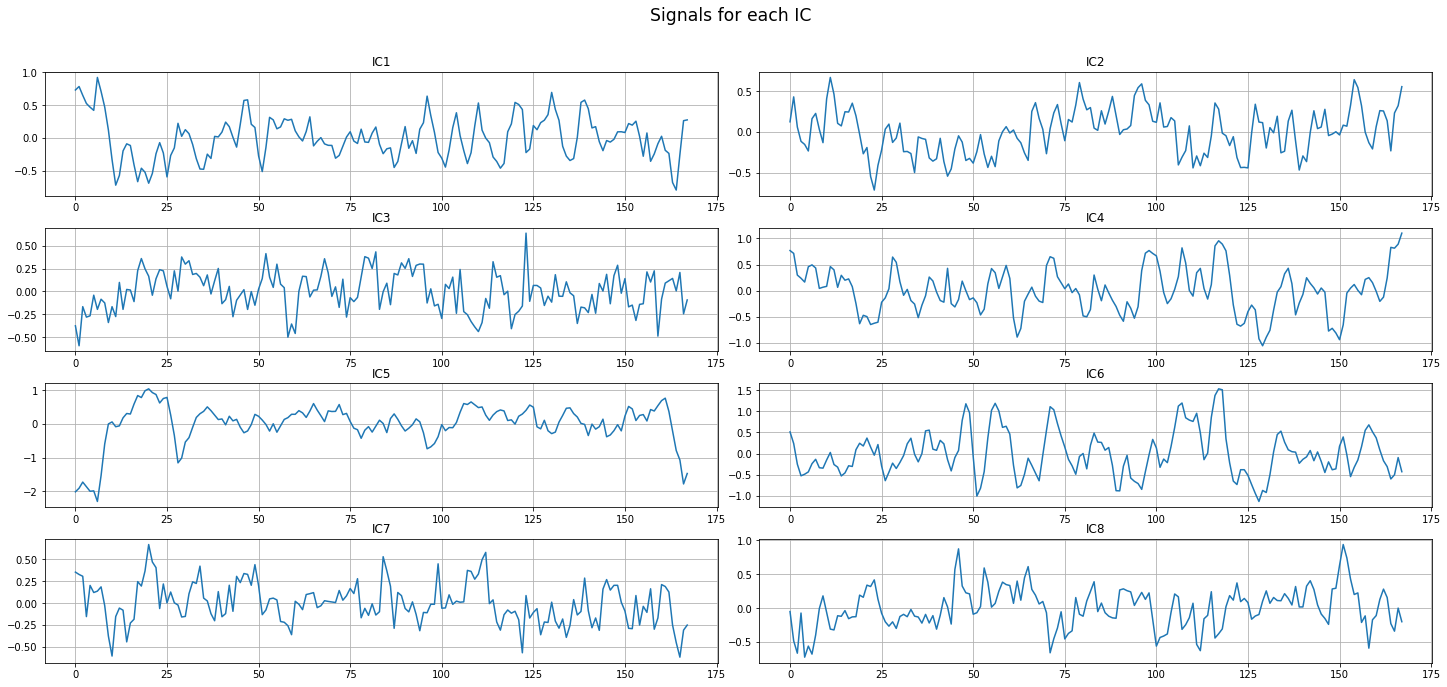

In [7]:
nc.plot_signals(df, title="Signals for each IC", figsize=(20, 10))

Since the aim of the project is developing a discrete DBN, the signal must be discretized; before doing so, the signal is normalized s.t. it will have mean $\mu=0$ and standard deviation $\sigma=1$ [[3](#third)]. 

In [8]:
# Normalize dataframe
df = (df - df.mean()) / df.std()

df.head(10)

,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8
0,2.213687,0.443372,-1.724817,1.755687,-3.352492,0.949613,1.501345,-0.180509
1,2.375008,1.540968,-2.723838,1.631081,-3.174603,0.439153,1.387145,-1.622997
2,1.967824,0.213127,-0.765451,0.682545,-2.872402,-0.468519,1.299174,-2.230244
3,1.589870,-0.416120,-1.289314,0.543293,-3.101460,-0.979043,-0.667387,-0.253241
4,1.417960,-0.552817,-1.224626,0.376075,-3.326246,-0.908676,0.853327,-2.426272
5,1.271545,-0.840555,-0.191102,1.046579,-3.303987,-0.808517,0.507208,-1.881797
6,2.795438,0.579541,-0.902241,1.128704,-3.828114,-0.447109,0.574532,-2.276449
7,2.149718,0.812190,-0.393187,0.993116,-2.557923,-0.253547,0.782134,-1.333482
8,1.422126,0.110187,-0.579026,0.099183,-0.991191,-0.624442,-0.135870,-0.036918
9,0.363177,-0.475057,-1.560957,0.151397,-0.007186,-0.643192,-1.616773,0.592011


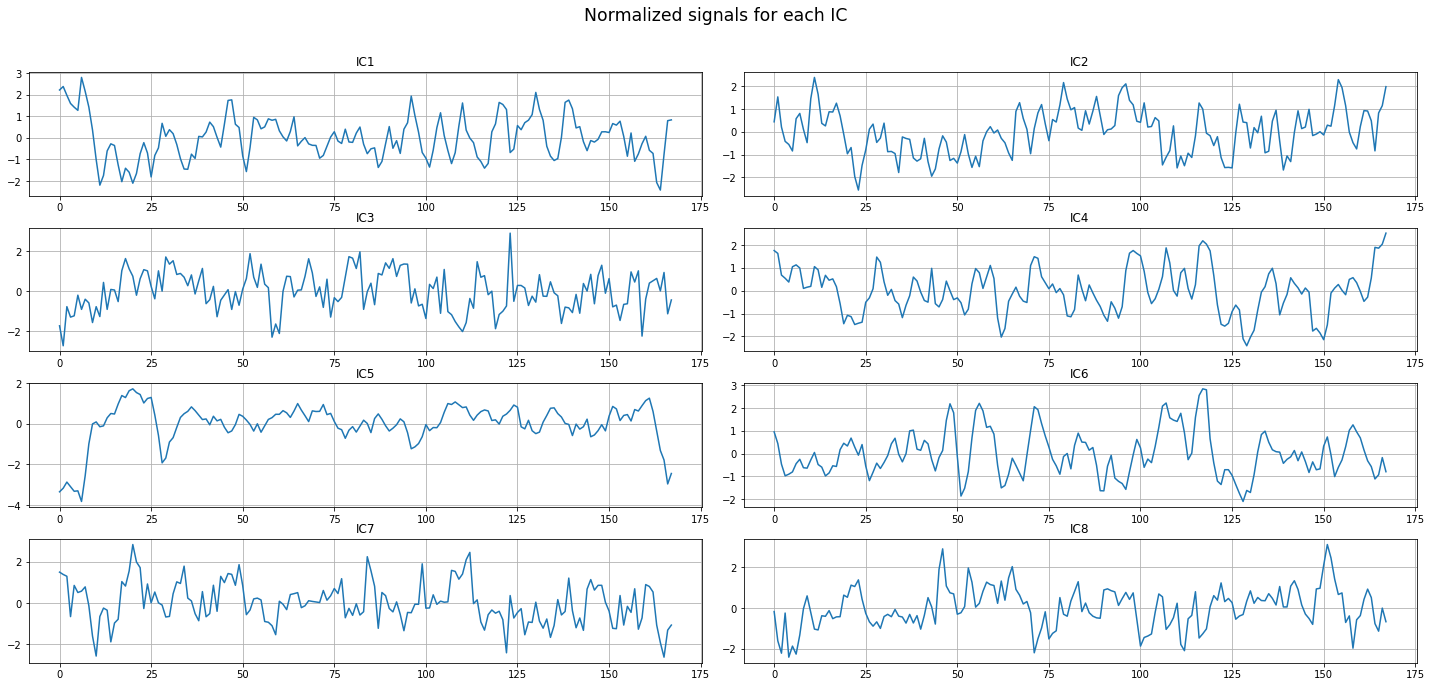

In [9]:
nc.plot_signals(df, title="Normalized signals for each IC", figsize=(20, 10))

After the normalization, the signal is discretized using four tiers; given $V_{min}$ and $V_{max}$, respectively the minimum and maximum values across the time series, then the current continuous value of the signal $V_{cont}$ is discretized according to the following rules [[3](#third)]:
- 'Very Low' if $V_{cont} \lt \frac{V_{min}}{2}$;
- 'Low' if $\frac{V_{min}}{2} \leq V_{cont} \lt 0$;
- 'High' if $0 \leq V_{cont} \lt \frac{V_{max}}{2}$;
- 'Very High' if $V_{cont} \geq \frac{V_{max}}{2}$.

In [10]:
list_of_series = [nc.discretize_series(df[col]) for col in df]
df = pd.concat(list_of_series, axis=1)
df.columns = labels

df.head(10)

,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8
0,Very High,High,Very Low,Very High,Very Low,High,Very High,Low
1,Very High,Very High,Very Low,Very High,Very Low,High,High,Very Low
2,Very High,High,Low,High,Very Low,Low,High,Very Low
3,Very High,Low,Low,High,Very Low,Low,Low,Low
4,Very High,Low,Low,High,Very Low,Low,High,Very Low
5,High,Low,Low,High,Very Low,Low,High,Very Low
6,Very High,High,Low,High,Very Low,Low,High,Very Low
7,Very High,High,Low,High,Very Low,Low,High,Very Low
8,Very High,High,Low,High,Low,Low,Low,Low
9,High,Low,Very Low,High,Low,Low,Very Low,High


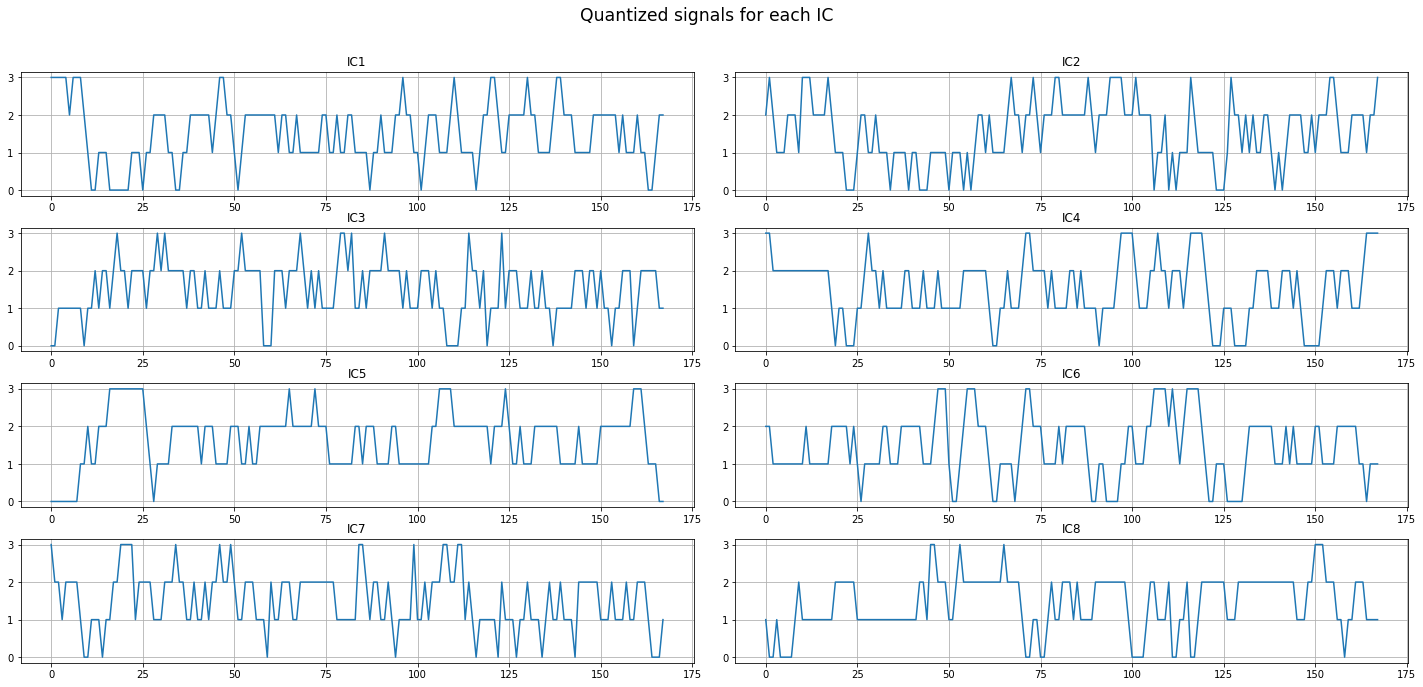

In [11]:
quantize_enc = {"Very Low": 0, "Low": 1, "High": 2, "Very High": 3}

nc.plot_signals(
    df.apply(lambda s: [quantize_enc[v] for v in s]),
    title="Quantized signals for each IC",
    figsize=(20, 10),
)

Then, we split the dataframe in a training set and in a test set; this will be useful to assess the DBNs performances in generating a synthetic time series.

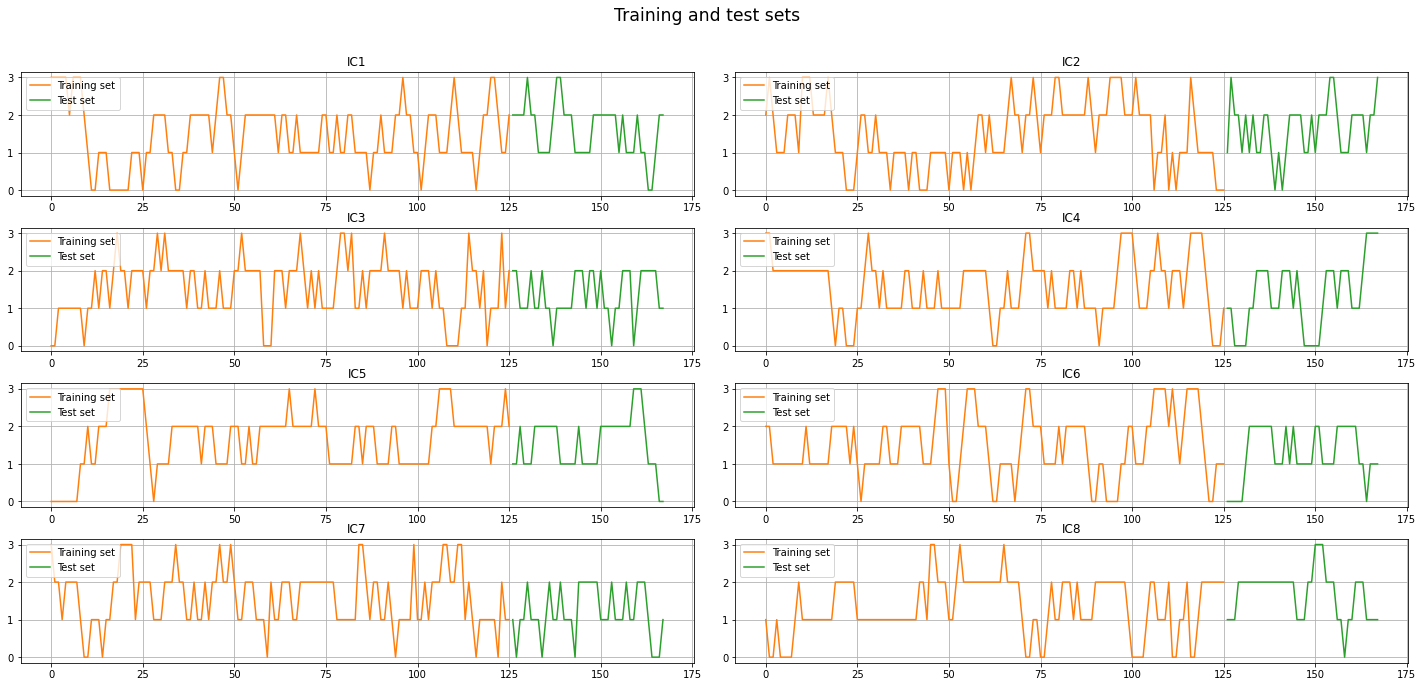

In [12]:
# Prepare mask
train_size = int(3 / 4 * len(df))
test_size = len(df) - train_size
train_mask = np.ones(train_size, dtype=bool)
test_mask = np.zeros(test_size, dtype=bool)
mask = np.concatenate([train_mask, test_mask])
# Split dataframe in training (3/4) and test (1/4) sets
df_train = df[mask]
df_test = df[~mask]

nc.plot_train_test_signals(
    df,
    title="Training and test sets",
    df_train=df_train.apply(lambda s: [quantize_enc[v] for v in s]),
    df_test=df_test.apply(lambda s: [quantize_enc[v] for v in s]),
    figsize=(20, 10),
)

The dDBN to be learnt is a 2-TBN, i.e. a discrete dynamic BN considering only 2 time slices. Therefore, the final preprocessing step consists in 'unrolling' the training set: the columns of the dataframe are doubled, s.t. the original columns will represent the value of the signal in the current time step, whereas the new ones will represent the value of the signal in the following time step. As a side effect, the length of each time series will be 125 instead of 126.

In [13]:
# Unroll time series and flatten
list_of_series = [nc.unroll_series(df_train[col]) for col in df]
list_of_series = [v for t in list_of_series for v in t]
# Create new labels and flatten
new_labels = [(f"{l}_T", f"{l}_T+1") for l in labels]
new_labels = [l for t in new_labels for l in t]

# Create new dataframe
unrolled_df_train = pd.concat(list_of_series, axis=1)
unrolled_df_train.columns = new_labels

print(f"Length of the time series after unrolling phase: {unrolled_df_train.shape[0]}")
print("-" * 50)
unrolled_df_train.head(10)

Length of the time series after unrolling phase: 125
--------------------------------------------------


,IC1_T,IC1_T+1,IC2_T,IC2_T+1,IC3_T,IC3_T+1,IC4_T,IC4_T+1,IC5_T,IC5_T+1,IC6_T,IC6_T+1,IC7_T,IC7_T+1,IC8_T,IC8_T+1
0,Very High,Very High,High,Very High,Very Low,Very Low,Very High,Very High,Very Low,Very Low,High,High,Very High,High,Low,Very Low
1,Very High,Very High,Very High,High,Very Low,Low,Very High,High,Very Low,Very Low,High,Low,High,High,Very Low,Very Low
2,Very High,Very High,High,Low,Low,Low,High,High,Very Low,Very Low,Low,Low,High,Low,Very Low,Low
3,Very High,Very High,Low,Low,Low,Low,High,High,Very Low,Very Low,Low,Low,Low,High,Low,Very Low
4,Very High,High,Low,Low,Low,Low,High,High,Very Low,Very Low,Low,Low,High,High,Very Low,Very Low
5,High,Very High,Low,High,Low,Low,High,High,Very Low,Very Low,Low,Low,High,High,Very Low,Very Low
6,Very High,Very High,High,High,Low,Low,High,High,Very Low,Very Low,Low,Low,High,High,Very Low,Very Low
7,Very High,Very High,High,High,Low,Low,High,High,Very Low,Low,Low,Low,High,Low,Very Low,Low
8,Very High,High,High,Low,Low,Very Low,High,High,Low,Low,Low,Low,Low,Very Low,Low,High
9,High,Low,Low,Very High,Very Low,Low,High,High,Low,High,Low,Low,Very Low,Very Low,High,Low


## Structure learning
After the preprocessing phase, the data is ready to be used to learn the dDBN. However, since `pgmpy` does not support learning a dynamic BN, the model that will be learnt will be a static BN. This is possible thanks to the 'unrolling' preprocessing step: in fact, the nodes belonging to the 'current' and 'next' time slices are treated as if they were standard nodes in a static BN. Therefore, the only things to keep in mind are the constraints due to the dynamic nature of the DBN [[4](#fourth)]:
- **causality constraint**: a node in the current time slice cannot be influenced by a node in the following time slice;
- **isochronal constraint**: a node in a time slice cannot influence other nodes in the same time slice;
- **continuity constraint**: a node in the current time slice will influence itself in the following time slice.

The search strategy employed is the **forward stepwise selection** [[3](#third)]:
- scan every 'next' node $X_n$;
- scan every 'current' node $X_c$;
- add $X_c$ as parent of $X_n$, measure structure score and remove such edge;
- re-add and keep only the edge producing the best score and repeat $indegree$ times.

Causality and isochronal constraints are already intrinsically taken into account by the search algorithm; on the other hand, continuity constraints are enforced when creating the initial model.

As in Burge et al.'s paper [[3](#third)], the *Bayesian Dirichlet equivalent uniform* prior (**BDeu**) score is used to assess the quality of a structure. Nevertheless, there are some differences in this implementation of forward stepwise selection w.r.t. the paper: in fact, the algorithm employed by Burge et al. also takes into account an additional node, representing the stimulus, connected to all the others; however, since in this case the stimulus (a movie) is active throughout all the fMRI recording, a node representing such stimulus would not carry any additional information, and thus it is not included. Moreover, Burge et al. do not impose any continuity constraint.

To speed-up the search, multi-core programming is exploited using `concurrent.futures.ProcessPoolExecutor` APIs.

The number of parents a 'next' node can have (i.e. $indegree$) is a hyper-parameter: it is possible to determine it using a grid search. The chosen parameter space is $[2..8]$: in particular, the lower bound forces one region to be connected to (at least) another one, in addition to its future state.

In [14]:
# Divide nodes into two categories, 'current' (time slice t) and 'next' (time slice t+1)
c_nodes, n_nodes = [], []
for i, n in enumerate(new_labels):
    if i % 2 == 0:
        c_nodes.append(n)
    else:
        n_nodes.append(n)

# Create BDeu estimator with default parameters
est = BDeuScore(unrolled_df_train)

param_space = [2, 3, 4, 5, 6, 7, 8]
start_time = time.time()
best_indeg = nc.grid_search(param_space, c_nodes, n_nodes, est)
print("-" * 50)
print(f"Best indegree of the model: {best_indeg}")
print(f"Total running time: {time.time() - start_time:.2f} s")

Testing indegree=2 with score -2398.75 [1.21 s]...
Testing indegree=3 with score -2653.94 [2.51 s]...
Testing indegree=4 with score -2911.69 [3.57 s]...
Testing indegree=5 with score -2915.06 [4.68 s]...
Testing indegree=6 with score -2789.52 [6.77 s]...
Testing indegree=7 with score -2673.24 [19.89 s]...
Testing indegree=8 with score -2643.85 [1.61 s]...
--------------------------------------------------
Best indegree of the model: 2
Total running time: 40.23 s


The grid search showed that the optimal number of parents for a 'next' node is $indegree=2$: therefore, the model's structure is searched using such value for the hyper-parameter.

In [15]:
static_model, score = nc.forward_stepwise_selection(
    c_nodes, n_nodes, best_indeg, est, verbose=True
)
print(f"Score of the model: {score:.2f}")

Using 6 cores
--------------------------------------------------
Finding parents of node IC1_T+1...
	 Added IC5_T with -2304.93
Finding parents of node IC2_T+1...
	 Added IC4_T with -2320.36
Finding parents of node IC3_T+1...
	 Added IC1_T with -2333.21
Finding parents of node IC4_T+1...
	 Added IC8_T with -2348.51
Finding parents of node IC5_T+1...
	 Added IC6_T with -2361.98
Finding parents of node IC6_T+1...
	 Added IC8_T with -2374.70
Finding parents of node IC7_T+1...
	 Added IC2_T with -2389.97
Finding parents of node IC8_T+1...
	 Added IC3_T with -2398.75
--------------------------------------------------
Running time: 1.30 s
Score of the model: -2398.75


In [16]:
nc.print_edges(static_model)

IC1_T
|-- IC1_T+1
|-- IC3_T+1
IC2_T
|-- IC2_T+1
|-- IC7_T+1
IC3_T
|-- IC3_T+1
|-- IC8_T+1
IC4_T
|-- IC2_T+1
|-- IC4_T+1
IC5_T
|-- IC1_T+1
|-- IC5_T+1
IC6_T
|-- IC5_T+1
|-- IC6_T+1
IC7_T
|-- IC7_T+1
IC8_T
|-- IC4_T+1
|-- IC6_T+1
|-- IC8_T+1
-------------------------
Total number of edges: 16


## Parameter learning
Once the structure is learnt, it is possible to also learn the conditional probability table (CPT) of the network. This can be done in two ways using `pgmpy`:
- **Maximum Likelihood Estimation (MLE)**: exploits relative frequencies to estimate the CPDs, and thus tends to overfit in case of small datasets;
- **Bayesian Parameter Estimation**: relies on prior CPDs (e.g. BDeu), and is more robust than MLE.

As in the forward stepwise selection, BDeu is chosen as CPD prior. By default, in the case of BDeu score the equivalent sample size, which is the number of generated uniform samples that are added to state counts for each parent configuration, is 10: thus, the same value is used for BDeu CPD prior.

To estimate the model's CPT, it suffices to call the `fit()` method of the `BayesianModel` class, pass to it an instance of `BayesianEstimator` and specify the prior.

In [17]:
static_model.fit(
    data=unrolled_df_train,
    estimator=BayesianEstimator,
    prior_type="BDeu",
    equivalent_sample_size=10,
)

print(f"Model check: {static_model.check_model()}")
print("-" * 25)
for cpd in static_model.get_cpds():
    print(f"CPT for {cpd.variable} node:")
    print(cpd, "\n")

Model check: True
-------------------------
CPT for IC1_T node:
+------------------+----------+
| IC1_T(High)      | 0.351852 |
+------------------+----------+
| IC1_T(Low)       | 0.396296 |
+------------------+----------+
| IC1_T(Very High) | 0.122222 |
+------------------+----------+
| IC1_T(Very Low)  | 0.12963  |
+------------------+----------+ 

CPT for IC1_T+1 node:
+--------------------+----------------------+----------------------+---------------------+---------------------+-----------------------+----------------------+----------------------+-----------------+---------------------+----------------------+------------------+----------------------+----------------------+---------------------+----------------------+-----------------+
| IC1_T              | IC1_T(High)          | IC1_T(High)          | IC1_T(High)         | IC1_T(High)         | IC1_T(Low)            | IC1_T(Low)           | IC1_T(Low)           | IC1_T(Low)      | IC1_T(Very High)    | IC1_T(Very High)     | IC1_

## From static to dynamic network
Now that both the structure of the network and its CPTs have been learnt, it's possible to convert the static model developed so far into a dynamic one.

In order to make inference methods work, `pgmpy` [would require to define all edges in the first time slice](https://github.com/pgmpy/pgmpy/issues/714); however, by doing so it could not be possible to model a dDBN with functional loops over time, which is a desired property of DBNs [[5](#fifth)] (in fact, [loops would appear](https://github.com/pgmpy/pgmpy/issues/1340) as if they were in the first time slice, thus violating the *acyclic* hypothesis of BNs).

Since it is still possible to define a `DynamicBayesianNetwork` with loops over time (but it's not possible to perform inference on that in `pgmpy`), as a design choice the dynamic model in the following section preserves loops; then, inference will instead be performed on the static model learned so far.

In [18]:
# Create support dictionary to find node ICX_t from ICX_t+1, and to find node ICX from ICX_t
next_to_curr_map = {n: c for c, n, in zip(c_nodes, n_nodes)}
stat_to_dyn_map = {new_l: l for l, new_l in zip(labels, new_labels[::2])}

dynamic_edges = [
    ((stat_to_dyn_map[c], 0), (stat_to_dyn_map[next_to_curr_map[n]], 1))
    for c, n in static_model.edges()
]
dynamic_model = DynamicBayesianNetwork(dynamic_edges)

nc.print_edges(dynamic_model)

IC1_0
|-- IC1_1
|-- IC3_1
IC2_0
|-- IC2_1
|-- IC7_1
IC3_0
|-- IC3_1
|-- IC8_1
IC4_0
|-- IC2_1
|-- IC4_1
IC5_0
|-- IC1_1
|-- IC5_1
IC6_0
|-- IC5_1
|-- IC6_1
IC7_0
|-- IC7_1
IC8_0
|-- IC4_1
|-- IC6_1
|-- IC8_1
-------------------------
Total number of edges: 16


The graphical representation of such network is shown below:

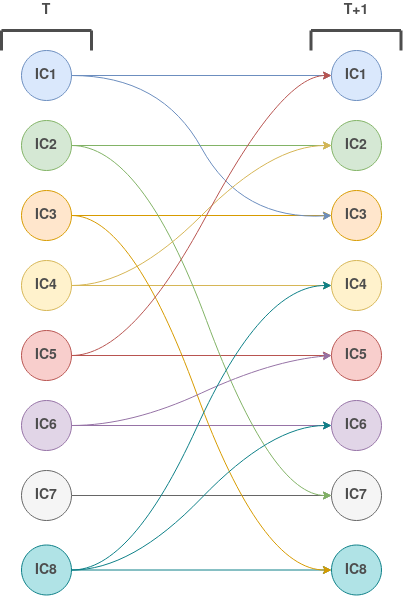

As it can be seen, almost every region influences other regions:

- IC8, with its 2 connections (excluding the one with its future self), is the most influential one;
- conversely, IC4 is connected only with its future self;
- every over region has 1 connection (excluding the one with its future self).

Moreover, certain regions form loops over time, for example:

- IC8 at time T influences IC6 at time T+1;
- IC6 at time T influences IC5 at time T+1;
- IC5 at time T influences IC1 at time T+1;
- IC1 at time T influences IC3 at time T+1;
- IC3 at time T influences IC8 at time T+1.

Now that the structure learnt using static BN is replicated in the dynamic BN, the CPTs must be also transferred.

In [19]:
dynamic_cpds = nc.to_dynamic_cpd(static_model, stat_to_dyn_map, next_to_curr_map)
dynamic_model.add_cpds(*dynamic_cpds)
dynamic_model.initialize_initial_state()

print(f"Model check: {dynamic_model.check_model()}")
print("-" * 25)
print("===== Time slice T =====")
for cpd in dynamic_model.get_cpds():
    print(f"CPT for {cpd.variable} node:")
    print(cpd, "\n")
print("===== Time slice T+1 =====")
for cpd in dynamic_model.get_cpds(time_slice=1):
    print(f"CPT for {cpd.variable} node:")
    print(cpd, "\n")

Model check: True
-------------------------
===== Time slice T =====
CPT for ('IC8', 0) node:
+-----------------------+-----------+
| ('IC8', 0)(High)      | 0.403704  |
+-----------------------+-----------+
| ('IC8', 0)(Low)       | 0.396296  |
+-----------------------+-----------+
| ('IC8', 0)(Very High) | 0.0481481 |
+-----------------------+-----------+
| ('IC8', 0)(Very Low)  | 0.151852  |
+-----------------------+-----------+ 

CPT for ('IC5', 0) node:
+-----------------------+-----------+
| ('IC5', 0)(High)      | 0.455556  |
+-----------------------+-----------+
| ('IC5', 0)(Low)       | 0.314815  |
+-----------------------+-----------+
| ('IC5', 0)(Very High) | 0.144444  |
+-----------------------+-----------+
| ('IC5', 0)(Very Low)  | 0.0851852 |
+-----------------------+-----------+ 

CPT for ('IC2', 0) node:
+-----------------------+----------+
| ('IC2', 0)(High)      | 0.351852 |
+-----------------------+----------+
| ('IC2', 0)(Low)       | 0.374074 |
+-------------------

## Network analysis
The `pgmpy` library provides tools to investigate several properties of the dDBN; for instance, it's possible to:
- Find every **independency** between the network's nodes, w.r.t. all possible given evidence, and in particular find **local independencies**.
- Find the **Markov blanket** of a node, namely the set consisting of the node's parents, children, and children's parents; such set makes the node conditionally independent of the rest of the network.
- Find the **active trails** between two nodes, namely the path connecting the two nodes and along which probabilistic inference can flow.

In [20]:
for n in dynamic_model.nodes():
    print(f"Markov blanket of node {n}: {dynamic_model.get_markov_blanket(node=n)}")
print("-" * 150)

nc.active_trail(dynamic_model, node=("IC6", 0))
nc.active_trail(dynamic_model, node=("IC6", 0), evidence=[("IC6", 1)])
nc.active_trail(
    dynamic_model,
    node=("IC6", 0),
    evidence=[("IC6", 1), ("IC5", 0), ("IC5", 1), ("IC8", 0)],
)

Markov blanket of node IC1_0: [IC1_1, IC3_0, IC3_1, IC5_0]
Markov blanket of node IC1_1: [IC1_0, IC1_1, IC1_2, IC3_1, IC3_2, IC5_0, IC5_1]
Markov blanket of node IC3_1: [IC1_0, IC1_1, IC3_0, IC3_1, IC3_2, IC8_1, IC8_2]
Markov blanket of node IC3_0: [IC1_0, IC3_1, IC8_0, IC8_1]
Markov blanket of node IC2_0: [IC2_1, IC4_0, IC7_0, IC7_1]
Markov blanket of node IC2_1: [IC2_0, IC2_1, IC2_2, IC4_0, IC4_1, IC7_1, IC7_2]
Markov blanket of node IC7_1: [IC2_0, IC2_1, IC7_0, IC7_1, IC7_2]
Markov blanket of node IC7_0: [IC2_0, IC7_1]
Markov blanket of node IC8_1: [IC3_0, IC3_1, IC4_1, IC4_2, IC6_1, IC6_2, IC8_0, IC8_1, IC8_2]
Markov blanket of node IC8_0: [IC3_0, IC4_0, IC4_1, IC6_0, IC6_1, IC8_1]
Markov blanket of node IC4_0: [IC2_0, IC2_1, IC4_1, IC8_0]
Markov blanket of node IC4_1: [IC2_1, IC2_2, IC4_0, IC4_1, IC4_2, IC8_0, IC8_1]
Markov blanket of node IC5_0: [IC1_0, IC1_1, IC5_1, IC6_0]
Markov blanket of node IC5_1: [IC1_1, IC1_2, IC5_0, IC5_1, IC5_2, IC6_0, IC6_1]
Markov blanket of node IC6_

As it can be seen, given no evidence there is an active trail between the node **IC6_0** and its descendants **IC5_1** and **IC6_1**; including **IC6_1** as evidence enables the flow of probabilistic inference from **IC6_0** to **IC8_0**, along the *V-structure*, and as a result **IC6_0** influences also the descendants of **IC8_0**. If evidence additionaly contains **IC5_0**, **IC5_1** and **IC8_0** (i.e. the Markov blanket of **IC6_0**), then the flow is blocked and the trails are no longer active.

In [21]:
start_time = time.time()
print("Finding independencies in the network...")
assertions = dynamic_model.get_independencies().get_assertions()
print(f"Running time: {time.time() - start_time:.2f} s")
print("-" * 50)

print(f"Number of possible independency assertions: {len(assertions)}")
print("\nSome independency assertions:")
print("\n\n".join(f"{a}" for a in sample(assertions, 3)))
print("-" * 120)

print("Local independencies:")
print(
    "\n\n".join(
        f"{dynamic_model.local_independencies([n])}" for n in dynamic_model.nodes()
    )
)

Finding independencies in the network...
Running time: 49.46 s
--------------------------------------------------
Number of possible independency assertions: 521036

Some independency assertions:
(IC2, 0 ⟂ IC4_0, IC8_1, IC3_0, IC1_0, IC6_0, IC1_1, IC5_0 | IC7_0, IC7_1, IC8_0, IC6_1, IC5_1, IC3_1, IC4_1)

(IC3, 1 ⟂ IC4_0, IC2_1, IC7_0, IC4_1, IC6_0, IC6_1 | IC8_1, IC2_0, IC7_1, IC8_0, IC3_0, IC5_1, IC1_1, IC5_0)

(IC1, 1 ⟂ IC4_0, IC2_1, IC8_1, IC7_1, IC8_0, IC6_1, IC7_0, IC6_0, IC3_0 | IC2_0, IC4_1, IC1_0, IC3_1)
------------------------------------------------------------------------------------------------------------------------
Local independencies:
(0, IC1 ⟂ IC4_0, IC2_1, IC8_1, IC2_0, IC7_1, IC8_0, IC6_1, IC5_1, IC7_0, IC4_1, IC5_0, IC6_0, IC3_0)

(IC1, 1 ⟂ IC4_0, IC2_1, IC7_0, IC8_1, IC2_0, IC7_1, IC8_0, IC6_1, IC5_1, IC3_1, IC4_1, IC6_0, IC3_0 | IC1_0, IC5_0)

(IC3, 1 ⟂ IC4_0, IC2_1, IC8_1, IC2_0, IC7_1, IC8_0, IC6_1, IC5_1, IC7_0, IC4_1, IC6_0, IC1_1, IC5_0 | IC1_0, IC3_0)

(0,

Due to the fact that the DBN is quite big (16 nodes), the number of independency assertions that can be made is high (about half a million); among these, the subset of local independencies (16, one per node) tells us that every node is independent of its non-descendants, given its parents (*local semantics*).

Independency assertions are implemented in `pgmpy` with the `IndependencyAssertion` class, consisting in 3 fields:
- `event1`: the independent random variable;
- `event2`: the random variable which `event1` is independent of;
- `event3`: the evidence that enables the independency.

Therefore, by exploiting the `IndependencyAssertion` class it is possible to further investigate some properties of the network, like the frequency in which a node appears in independency assertions.

In [22]:
def node_frequency(node, is_evidence=False):
    if is_evidence:
        return Counter(node for a in assertions if node in a.event3)[node]
    else:
        return Counter(node for a in assertions if node in a.event1)[node]


start_time = time.time()
var_freq = {node: node_frequency(node) for node in dynamic_model.nodes()}
max_var = max(var_freq, key=var_freq.get)
print(
    f"Node which appears the most ({var_freq[max_var]}) as random variable: {max_var}"
)
min_var = min(var_freq, key=var_freq.get)
print(
    f"Node which appears the least ({var_freq[min_var]}) as random variable: {min_var}"
)
evid_freq = {
    node: node_frequency(node, is_evidence=True) for node in dynamic_model.nodes()
}
max_evid = max(evid_freq, key=evid_freq.get)
print(f"Node which appears the most ({evid_freq[max_evid]}) as evidence: {max_evid}")
min_evid = min(evid_freq, key=evid_freq.get)
print(f"Node which appears the least ({evid_freq[min_evid]}) as evidence: {min_evid}")
print("-" * 50)
print(f"Running time: {time.time() - start_time:.2f} s")

Node which appears the most (0) as random variable: IC1_0
Node which appears the least (0) as random variable: IC1_0
Node which appears the most (245539) as evidence: IC8_0
Node which appears the least (243100) as evidence: IC2_1
--------------------------------------------------
Running time: 7.90 s


## Inference
As stated before, inference will be performed on the static network, since, due to `DynamicBayesianNetwork`'s limitation, the developed dDBN (with loops over time) does not support inference.

There exist two macro-categories for inference algorithms:
- **exact**: compute the exact inference at higher cost;
- **approximated**: compute the approximated inference by exploiting random sampling at lower cost.

Since the modelled dDBN is not too complex, exact inference, and in particular **variable elimination**, can be employed.

Variable elimination consists in summing out hidden non-query variables and storing the intermediate results (*factors*), in order to avoid recomputations. The order in which variables are eliminated can heavily impact performance: however, finding the optimal order is an $NP-hard$ problem, and thus some heuristics can be employed to optimize the search. In particular, `pgmpy` supports the following heuristics:
- `MinFill`: the cost eliminating a node is the number of additional edges needed to compensate the elimination;
- `MinNeighbors`: the cost eliminating a node is the number of its neighbours;
- `MinWeight`: the cost eliminating a node is the product of the weights of its neighbours;
- `WeightedMinFill`: the cost eliminating a node is the sum of the weights of additional edges needed to compensate the (the weight of an edge is the product of the weights of its two vertices).

It is possible to compare both the order found by the four heuristics and the respective time required.

In [23]:
infer = VariableElimination(static_model)
infer._initialize_structures()
# Compare different heuristics
nc.compare_heuristics(infer, ["IC8_T"])
nc.compare_heuristics(infer, ["IC3_T"], evidence={"IC3_T+1": "High"})
nc.compare_heuristics(infer, ["IC7_T+1"])
nc.compare_heuristics(
    infer, ["IC2_T+1"], evidence={"IC6_T+1": "Very High", "IC8_T+1": "Low"}
)


Using 6 cores
--------------------------------------------------
The heuristics have found different elimination orders for variables ['IC8_T'] with no evidence:
MinFill: ['IC7_T+1', 'IC4_T+1', 'IC4_T', 'IC5_T+1', 'IC5_T', 'IC7_T', 'IC6_T', 'IC8_T+1', 'IC3_T', 'IC2_T+1', 'IC6_T+1', 'IC3_T+1', 'IC2_T', 'IC1_T', 'IC1_T+1'] [0.00659 s]
MinNeighbors: ['IC7_T+1', 'IC7_T', 'IC4_T+1', 'IC5_T+1', 'IC8_T+1', 'IC2_T+1', 'IC2_T', 'IC4_T', 'IC6_T+1', 'IC6_T', 'IC5_T', 'IC1_T+1', 'IC3_T+1', 'IC1_T', 'IC3_T'] [0.00551 s]
MinWeight: ['IC7_T+1', 'IC7_T', 'IC4_T+1', 'IC5_T+1', 'IC8_T+1', 'IC2_T+1', 'IC2_T', 'IC4_T', 'IC6_T+1', 'IC6_T', 'IC5_T', 'IC1_T+1', 'IC3_T+1', 'IC1_T', 'IC3_T'] [0.00557 s]
WeightedMinFill: ['IC7_T+1', 'IC7_T', 'IC4_T+1', 'IC5_T+1', 'IC8_T+1', 'IC2_T+1', 'IC2_T', 'IC4_T', 'IC6_T+1', 'IC6_T', 'IC5_T', 'IC1_T+1', 'IC3_T+1', 'IC1_T', 'IC3_T'] [0.0064 s]

Using 6 cores
--------------------------------------------------
The heuristics have found different elimination orders for variab

As it can be seen, the difference between heuristics in terms of performance is negligible. Below, the same queries are performed using different heuristics.

In [24]:
# Execute query
nc.exec_query(infer, ["IC8_T"])
nc.exec_query(
    infer, ["IC3_T"], evidence={"IC3_T+1": "High"}, heuristics="WeightedMinFill"
)
nc.exec_query(infer, ["IC7_T+1"], heuristics="MinWeight")
nc.exec_query(
    infer,
    ["IC5_T+1"],
    evidence={"IC3_T+1": "Very High", "IC4_T+1": "Low"},
    heuristics="MinNeighbors",
)


Probability query for ['IC8_T'] given no evidence computed with MinFill heuristics:
+------------------+--------------+
| IC8_T            |   phi(IC8_T) |
+==================+==============+
| IC8_T(High)      |       0.4037 |
+------------------+--------------+
| IC8_T(Low)       |       0.3963 |
+------------------+--------------+
| IC8_T(Very High) |       0.0481 |
+------------------+--------------+
| IC8_T(Very Low)  |       0.1519 |
+------------------+--------------+
Running time: 0.00750 s

Probability query for ['IC3_T'] given {'IC3_T+1': 'High'} computed with WeightedMinFill heuristics:
+------------------+--------------+
| IC3_T            |   phi(IC3_T) |
+==================+==============+
| IC3_T(High)      |       0.4592 |
+------------------+--------------+
| IC3_T(Low)       |       0.3786 |
+------------------+--------------+
| IC3_T(Very High) |       0.1335 |
+------------------+--------------+
| IC3_T(Very Low)  |       0.0287 |
+------------------+--------------

## Sampling synthetic data
 The `pgmpy` library also allows to randomly take sample from the Bayesian network: in particular, it provides `BayesianModelSampling` class to perform sampling techniques, as **forward sampling** (when no evidence is provided) and **rejection sampling** (sampling is repeated until samples match the evidence provided).

By chaining subsequent rejection samples, it is possible to **generate a synthetic time series**.

In [25]:
bayes_sampler = BayesianModelSampling(static_model)

df_synth = nc.generate_time_series(
    sampler=bayes_sampler, length=test_size, labels=labels
)
df_synth.head(10)

  0%|          | 0/42 [00:00<?, ?it/s]

,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8
0,High,High,Low,High,High,Low,Very Low,High
1,High,Very High,High,Very High,High,Low,Very Low,Low
2,High,High,High,Very High,High,Very High,Low,Low
3,High,Very Low,High,Very High,High,Very High,Low,Low
4,Low,Very Low,High,High,High,High,Low,Low
5,Low,Low,Low,High,High,High,High,High
6,High,High,High,High,Low,Low,Very High,Low
7,Low,Very High,Very High,Low,High,Low,Very High,Low
8,High,Very High,Low,Low,High,Low,Low,Low
9,Low,Very High,High,Low,High,Low,High,Low


Before actually comparing the synthetic time series with the original one, it is better to preliminarily define a baseline: to do so, a random time series is generated.

In [26]:
# Create baseline dataframe with random series
inverse_enc = {0: "Very Low", 1: "Low", 2: "High", 3: "Very High"}
enc_fun = lambda x: inverse_enc[x]

baseline_list = [
    pd.Series(np.random.randint(low=0, high=4, size=test_size)).map(enc_fun)
    for _ in range(8)
]
df_base = pd.concat(baseline_list, axis=1)
df_base.columns = labels

df_base.head(10)

,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8
0,Very Low,High,Very Low,Very High,Very High,Very High,Very Low,Very High
1,Low,Low,Very Low,Very High,Very Low,Low,Low,Very High
2,Very High,High,Very Low,Low,Low,High,Very Low,High
3,High,High,High,High,Very Low,High,Very Low,High
4,Low,Very High,Very Low,Very High,Low,High,Very Low,Low
5,High,High,Very Low,Very Low,Very Low,Very High,Low,Low
6,Very High,Low,High,Low,Very High,High,High,Very High
7,Low,Low,Very Low,High,Low,Very High,High,High
8,Low,Very Low,Very High,Low,Very Low,Low,Very Low,Very Low
9,Very Low,High,High,Very High,High,High,Low,Very Low


Below, the synthetic time series and the baseline are displayed together with the original test set.

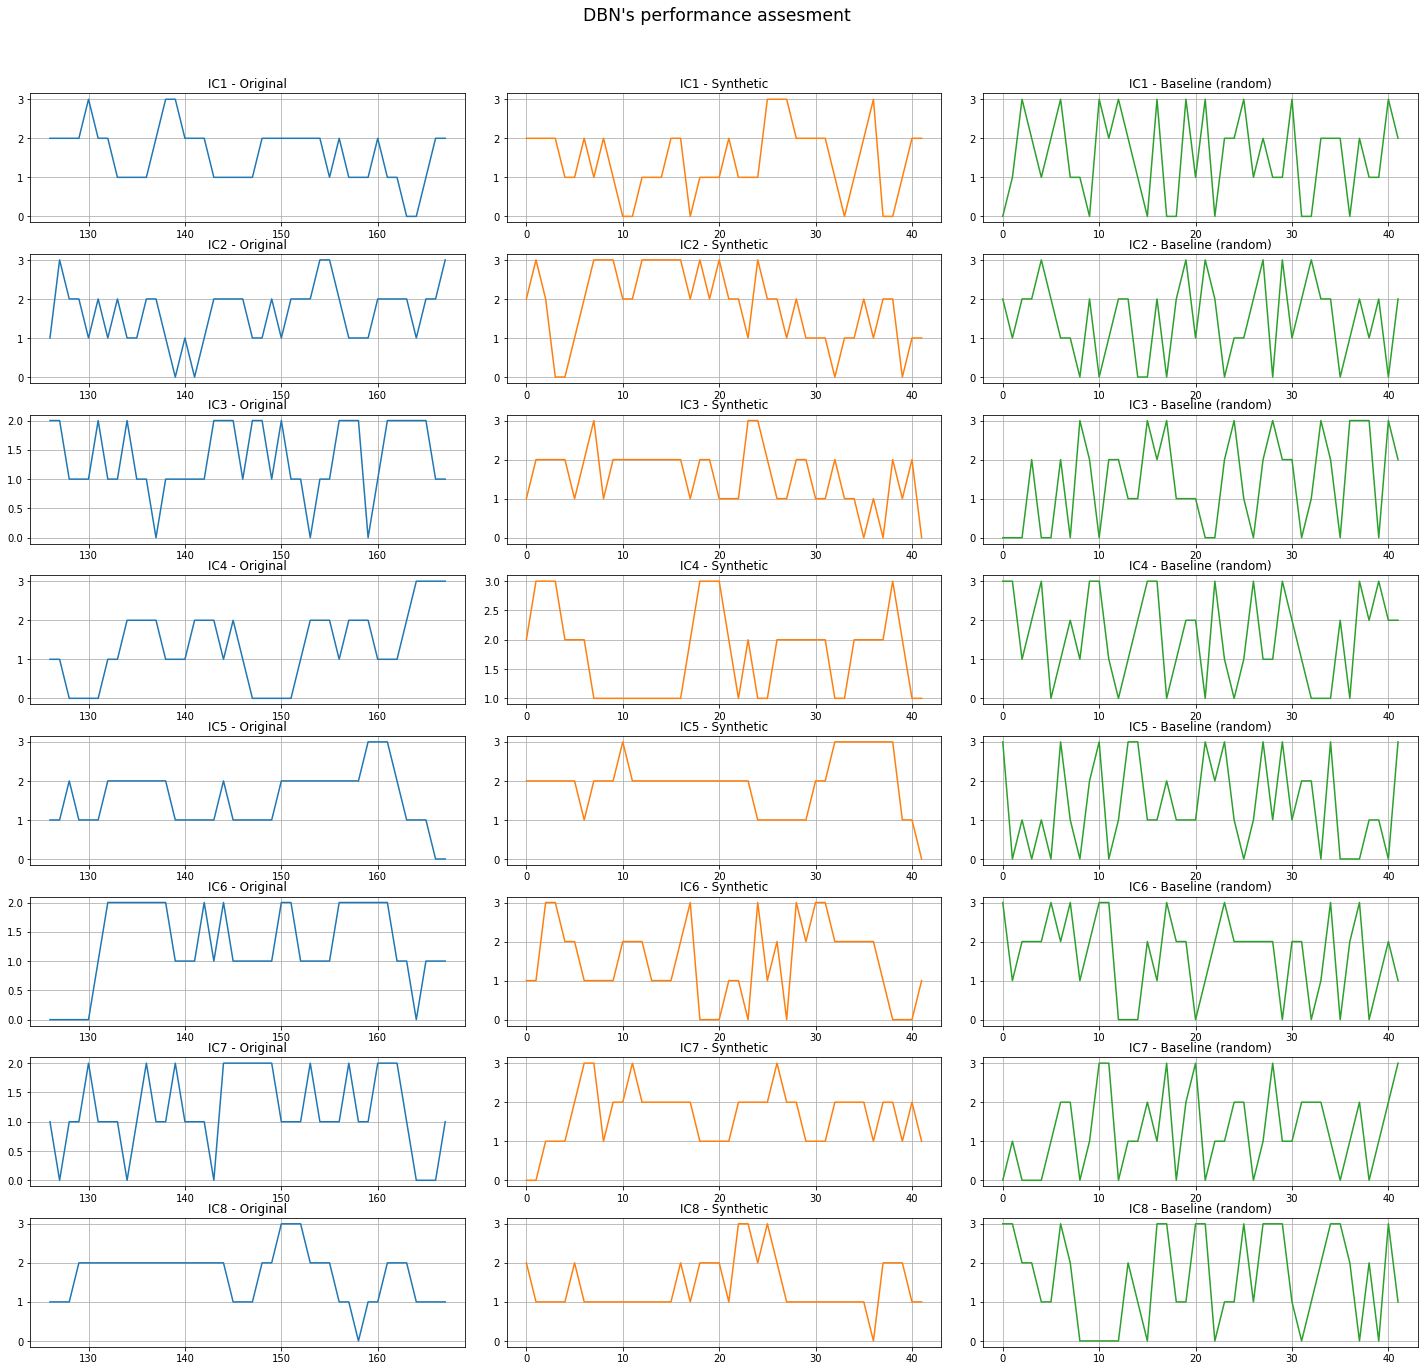

In [27]:
nc.plot_synth_signal(
    df1=df_test.apply(lambda s: [quantize_enc[v] for v in s]),
    df2=df_synth.apply(lambda s: [quantize_enc[v] for v in s]),
    df3=df_base.apply(lambda s: [quantize_enc[v] for v in s]),
    title="DBN's performance assesment",
    figsize=(20, 20),
)

From a purely visual inspection, it seems evident that the synthetic time series is more similar to the original test set than the random baseline; to objectively measure such similarity, the **Dynamic Time Warping** (DTW) metric can be employed: it is included in the `tslearn` library (`dtw` function), among other tools for time series analysis.

Such metric will be employed to measure the distances between the original test set and the synthetic time series, and between the original test set and the baseline, in order to assess the quality of the dDBN modelled.

In [28]:
enc_fun = lambda x: quantize_enc[x]

# Transform dataframes into multivariate time series
s = np.vectorize(enc_fun)(df_test.to_numpy())
s_synth = np.vectorize(enc_fun)(df_synth.to_numpy())
s_base = np.vectorize(enc_fun)(df_base.to_numpy())
# Compute DTW
sim_synth = dtw(s, s_synth)
sim_base = dtw(s, s_base)
print(f"DTW distance between original and synthetic time series: {sim_synth:.2f}")
print(f"DTW distance between original time series and baseline: {sim_base:.2f}")

DTW distance between original and synthetic time series: 18.14
DTW distance between original time series and baseline: 22.61


## Conclusions
As it can be seen, according to the DTW distance the synthetic data are slightly more similar to the test set w.r.t. the random baseline: despite the fact that there is room for improvement, the dDBN proposed already manages to simulate neural connectivity in the regions considered up to a certain degree of accuracy.

## References
<a name="first">[1]</a> [Richardson et al. - Development of the social brain from age three totwelve years](https://www.nature.com/articles/s41467-018-03399-2.pdf)

<a name="second">[2]</a> [Varoquaux et al. - CanICA: Model-based extraction of reproduciblegroup-level ICA patterns from fMRI time series](https://arxiv.org/pdf/0911.4650.pdf)

<a name="third">[3]</a> [Burge et al. - Discrete Dynamic Bayesian Network Analysis of fMRI data](https://www.sciencedirect.com/science/article/pii/S0888613X1300073X)

<a name="fourth">[4]</a> [De Campos et al. - Efficient Structure Learning of Bayesian Networks using Constraints](https://jmlr.org/papers/volume12/decampos11a/decampos11a.pdf)

<a name="fifth">[5]</a> [Anne Smith - Bayesian Networks](https://synergy.st-andrews.ac.uk/vannesmithlab/research/bayesian-networks/)